<a href="https://colab.research.google.com/github/sandeeppalakkal/ML_Datascience_Practice/blob/master/Dog_Cat_Classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get & Prepare Data

In [0]:
import tensorflow as tf
tf.enable_eager_execution
import pdb

In [2]:
# Get data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# data paths
train_data_path = '/content/gdrive/My Drive/Datasets/DogCat/train'
test_data_path = '/content/gdrive/My Drive/Datasets/DogCat/test1'

In [4]:
 # Get data size
import glob
train_data_imgs = sorted(glob.glob(train_data_path+'/*.jpg'))
test_data_imgs = sorted(glob.glob(test_data_path+'/*.jpg'))
train_data_size = len(train_data_imgs)
test_data_size = len(test_data_imgs)
print('Training data size = %d' % train_data_size)
print('Test data size = %d' % test_data_size)

Training data size = 0
Test data size = 0


In [0]:
# Annotation
import os
train_data_imgs = list(map(os.path.basename,train_data_imgs))
train_data_annot = list(map(lambda x: int(x[:3] != 'cat'),train_data_imgs))
data_dict = dict(zip(train_data_imgs,train_data_annot))

In [0]:
#data_dict.items()

### Train-Validation Data Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_x,test_x,train_y,test_y = train_test_split(list(data_dict.keys()),list(data_dict.values()),train_size = 0.6,random_state=33)
test_x,val_x,test_y,val_y = train_test_split(test_x,test_y,train_size = 0.5,random_state=65)

In [0]:
print(len(data_dict.keys()))
#print(len(train_y),len(val_y),len(test_y))

25000


In [0]:
import json

In [0]:
# data details
data_path = '/content/gdrive/My Drive/Datasets/DogCat/train'
train_json = '/content/gdrive/My Drive/Datasets/DogCat/train.json'
val_json = '/content/gdrive/My Drive/Datasets/DogCat/validation.json'
test_json = '/content/gdrive/My Drive/Datasets/DogCat/test.json'

In [0]:
def json_write(data,json_file):
  json.dump(data,open(json_file,'w'))

In [0]:
json_write(dict(zip(train_x,train_y)),train_json)
json_write(dict(zip(val_x,val_y)),val_json)
json_write(dict(zip(test_x,test_y)),test_json)

## Image Preprocessing Functions

In [0]:
# Image preprocessing
def preprocess_image(image,size=(224,224)):
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.resize_images(image,list(size))
  image /= 255.0
  return image

In [0]:
# load & preprocess
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  image = preprocess_image(image)
  return image

## TF Dataset

In [0]:
# create tf dataset
def create_tf_image_dataset(img_paths,img_labels):  
  # load & preprocess image & label
  def _load_and_preprocess_from_path_label(path,label):
    return load_and_preprocess_image(path), label
  
  ds = tf.data.Dataset.from_tensor_slices((img_paths,img_labels))
  ds = ds.map(_load_and_preprocess_from_path_label)
  return ds

## Model Training

### TF Data Input Pipeline

In [0]:
# get data annotations
def json_load(json_file):
  return json.load(open(json_file,'r'))

#val_list = json_load(val_json)
train_list,val_list,test_list = map(json_load,[train_json,val_json,test_json])

In [0]:
import os

In [0]:
def join_path(path,file):
  return os.path.join(path,file)

train_list = {join_path(data_path,k):v for k,v in train_list.items()}
val_list = {join_path(data_path,k):v for k,v in val_list.items()}
test_list = {join_path(data_path,k):v for k,v in test_list.items()}

In [0]:
import itertools

In [0]:
train_list = dict(itertools.islice(train_list.items(),1000))
val_list = dict(itertools.islice(val_list.items(),500))
test_list = dict(itertools.islice(test_list.items(),500))

In [17]:
print(len(train_list),len(val_list),len(test_list))

1000 500 500


In [0]:
def create_tf_image_dataset_from_dict(data_dict):
  return create_tf_image_dataset(list(data_dict.keys()),list(data_dict.values()))

train_ds,val_ds,test_ds = map(create_tf_image_dataset_from_dict,[train_list,val_list,test_list])

In [19]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def data_pipeline(ds,data_size,batch_size):
  ds = train_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=data_size))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [0]:
BATCH_SIZE = 32
train_ds_ = data_pipeline(train_ds,len(train_list),BATCH_SIZE)
val_ds_ = data_pipeline(val_ds,len(val_list),BATCH_SIZE)
test_ds_ = data_pipeline(test_ds,len(test_list),BATCH_SIZE)

## Training in Keras

In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False)
mobile_net.trainable = False

In [0]:
resnet50 = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False)
resnet50.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
def change_range(image,label):
  return 2*image-1, label

keras_train_ds = train_ds_.map(change_range)
keras_val_ds = val_ds_.map(change_range)
keras_test_ds = test_ds_.map(change_range)

In [0]:
image_batch, label_batch = next(iter(keras_train_ds))

In [0]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(?, 7, 7, 1280)


In [0]:
label_names = ['cat','dog']
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names),
                       kernel_regularizer=tf.keras.regularizers.l2(0.0001))])

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [0]:
len(model.trainable_variables) 

2

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
history = model.fit(keras_train_ds, validation_data=keras_train_ds,validation_steps=10,
          validation_freq=1, epochs=10, steps_per_epoch=len(train_list)//BATCH_SIZE)

Epoch 1/10
31/31 [==============================] - 19s 613ms/step - loss: 0.6127 - acc: 0.7046 - val_loss: 0.5981 - val_acc: 0.7000
Epoch 2/10
31/31 [==============================] - 12s 377ms/step - loss: 0.6009 - acc: 0.7127 - val_loss: 0.5163 - val_acc: 0.7281
Epoch 3/10
31/31 [==============================] - 12s 382ms/step - loss: 0.5850 - acc: 0.7087 - val_loss: 0.6714 - val_acc: 0.7063
Epoch 4/10
31/31 [==============================] - 12s 401ms/step - loss: 0.6015 - acc: 0.7107 - val_loss: 0.5700 - val_acc: 0.7125
Epoch 5/10
31/31 [==============================] - 13s 425ms/step - loss: 0.5692 - acc: 0.7127 - val_loss: 0.5420 - val_acc: 0.7312
Epoch 6/10
31/31 [==============================] - 11s 350ms/step - loss: 0.5763 - acc: 0.7228 - val_loss: 0.5591 - val_acc: 0.7250
Epoch 7/10
31/31 [==============================] - 11s 345ms/step - loss: 0.5459 - acc: 0.7379 - val_loss: 0.5635 - val_acc: 0.7000
Epoch 8/10
31/31 [==============================] - 10s 338ms/step - 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


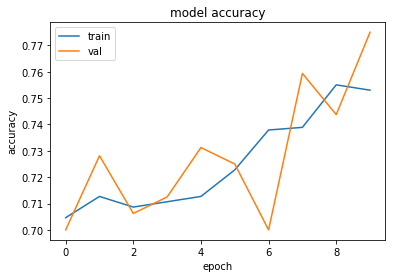

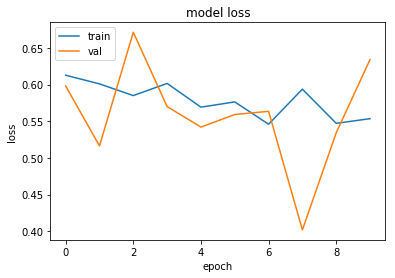

In [0]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# serialize model to JSON
model_path = '/content/gdrive/My Drive/Datasets/DogCat/'
model_json = model.to_json()
with open(os.path.join(model_path,"model.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(model_path,"model.h5"))
print("Saved model to disk")

Saved model to disk
